In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import numpy as np
import pandas as pd
import spotlob
import tifffile as tf
import matplotlib.pyplot as plt
import imageio as im
import cv2

In [3]:
from PIL import Image

In [4]:
from spotlob.process_steps import Reader
from spotlob.parameters import NumericRangeParameter
from spotlob.spim import Spim

In [5]:
class TifReader(Reader):
    """
    Reads an image from a file as an RGB file.
    Only image format `tif` is supported.
    It uses `tifffile.memmap`.
    """

    def __init__(self):
        pars = [NumericRangeParameter("width_percent", 100, 0, 100),
                NumericRangeParameter("height_percent", 100, 0, 100),
                NumericRangeParameter("x0_percent", 0, 0, 100),
                NumericRangeParameter("y0_percent", 0, 0, 100)]
        
        self._preview_image_cache = None

        super(TifReader, self).__init__(self.partial_read, pars)

    def _absolute_ROI_corners(self, filepath, width_percent, height_percent, x0, y0):
        
        if os.path.exists(filepath):
            im = Image.open(filepath)
            w, h = im.size
            
            new_w = int(w * width_percent / 100)
            new_h = int(h * height_percent / 100)
            x0 = int(w * x0 / 100)
            y0 =  int(h * y0 / 100)
            x1 = x0+new_w
            y1 = y0+new_h

            return x0,y0, min(x1,w),min(y1,h)
        else:
            raise IOError(f"File {filepath} not found")

    def partial_read(self, filepath, width_percent, height_percent, x0_percent, y0_percent): # -> tuple(np.ndarray, dict)
        """
        Returns an array of a part of an .tif image.
        The arguments must be percentages, even the startingpoint is relative.
        Starting Point is the top-left corner.
        """
        x0,y0, x1,y1 = self._absolute_ROI_corners(filepath, 
                                                    width_percent, 
                                                    height_percent, 
                                                    x0_percent, 
                                                    y0_percent)
        
        return tf.memmap(filepath, dtype= np.uint8)[y0:y1, x0:x1, :], {"ROI": (x0,y0,x1,y1)}
    
    def preview(self, spim):
        filepath = spim.metadata["filepath"]
        x0,y0, x1,y1 = self._absolute_ROI_corners(filepath, 
                                                  self.parameters["width_percent"].value, 
                                                  self.parameters["height_percent"].value,
                                                  self.parameters["x0_percent"].value,
                                                  self.parameters["y0_percent"].value)

        # read entire image
        if self._preview_image_cache is None:
            self._preview_image_cache = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

        image = self._preview_image_cache.copy()
        
        start_point = x0,y0
        end_point = x1,y1

        image = (image*0.5).astype(np.uint8) # darken image
        image[y0:y1, x0:x1] *= 2             # brighten ROI

        # draw rectangle
        image = cv2.rectangle(image, start_point, end_point, (0,255,0), thickness=1)
        
        return image
        

In [6]:
# Creates a testtif.tif image
width = 1000
height = 1000
array = np.zeros([height, width, 3], dtype= np.uint8)
array[:height//2,:width//2] = [255, 0, 0]
array[:height//2,width//2:] = [0, 0, 255]   
array[height//2:,:width//2] = [255, 100, 255] 
array[height//2:,width//2:] = [100, 100, 255]
im.imwrite("testtif.tif", array)

In [7]:
h = TifReader()
test_spim = Spim.from_file("testtif.tif")
print(test_spim._image)
print(test_spim.metadata)
print(test_spim.stage)
print(test_spim.cached)

None
{'filepath': 'testtif.tif'}
0
False


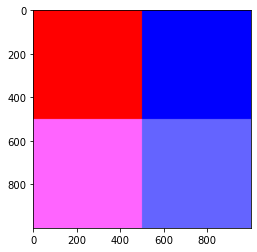

In [8]:
plt.imshow(test_spim.read(h).image)

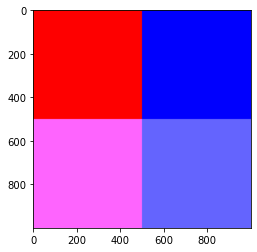

In [9]:
plt.imshow(h.preview(test_spim))


In [10]:
# 
# array, metadata = h.partial_read("testtif.tif", 20, 15, 40, 40)
# plt.imshow(array)
# print(metadata)

In [11]:
from spotlob.defaults import default_pipeline
filename = "testtif.tif"

In [12]:
gui = spotlob.make_gui(filename)

In [13]:
gui.pipeline = gui.pipeline.replaced_with(TifReader())

In [14]:
%matplotlib widget
spotlob.show_gui(gui)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Button(description='Evaluate', style=ButtonStyle())